# EXERCISE 2:

Consider the dataset WorldMarkts99 20.RDS containing price history from 1999- 01-01 to 2020-04-30 of 11 market indices worldwide plus VLIC and VIX. The script HW1 markets.R will help you retrieve data (optionally) and organise it for the rest of this exercise. For the epoch assigned to your team in the Google spreadsheet, the corresponding team must do: A full causality analysis for the first four lags of the returns time series of these 11 market indices, and a full causality analysis for the first four lags of the volatilities series of these market return indices (this is known as volatility spill-over).
Do this analysis sampling the series first weekly and then monthly periods. Estimate volatility using EMA (see Prob. 1). Tabulate and comment your results (four tables, one for returns, other for volatility and each for weekly and for monthly sampling), so that cause → effect goes from row to column, and each entry a 4-vector of {0, 1} indicating causality (1) or not (0) for each lag (coordinate). Example
India Brazil UK . . . USA (1,0,1,1) (0,1,1,0) (1,1,1,0) ... Brazil (0,0,1,1) (1,0,0,0) ...
. . . . .
so, first entry means US → India at lags 1,3,4.
Causality should be considered significant at the 5% level. Comment your results. Among which countries there is true causality, or contemporaneous correlation? Can you device a network of causalities?


# INDEX:

0. [DATA AND LIBRARY IMPORTS](#0.-DATA-AND-LIBRARY-IMPORTS)

1. [TIMEFRAME TRANSFORMATION](#1.-TIMEFRAME-TRANSFORMATION)

2. [FEATURE CREATION](#2.-FEATURE-CREATION)

3. [STATIONARITY CHECK](#3.-STATIONARITY-CHECK)

4. [CAUSALITY ANALYSIS](#4.-CAUSALITY-ANALYSIS)

# 0. DATA AND LIBRARY IMPORTS

[Back to Index](#INDEX)

In [411]:
import pandas as pd 
import numpy as np
import pyreadr
import os
import warnings

# Suppress specific FutureWarnings from statsmodels
warnings.filterwarnings("ignore", category=FutureWarning, module="statsmodels")

In [412]:
all_market_data = {}

for file in os.listdir('data'):
    file_name = 'data/' + file
    key_name = file.split('.')[0]
    all_market_data[key_name] = pd.read_csv(file_name, index_col=0)

print(all_market_data.keys())

dict_keys(['HSCE', 'VLIC', 'MXX', 'N225', 'BVSP', 'GSPC', 'JKSE', 'IBEX', 'VIX', 'BSESN', 'GDAXI', 'FTSE', 'TWII'])


treat outliers and missing data

In [413]:
# find outliers with iqr
def remove_outliers(data):
    for col in data.columns:
        threshold = 2

        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1

        # replace outliers with NA
        data.loc[(data[col] < (Q1 - threshold * IQR)) | (data[col] > (Q3 + threshold * IQR)), col] = np.nan
    return data 

In [414]:

for key in all_market_data.keys(): 
    all_market_data[key].columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']
    all_market_data[key] = remove_outliers(all_market_data[key])
    ffill = all_market_data[key].ffill()
    bfill = all_market_data[key].bfill()
    all_market_data[key] = ffill+bfill / 2
    all_market_data[key]['Returns'] = all_market_data[key]['Adj Close'].pct_change()
    all_market_data[key] = all_market_data[key][1:-1]
    # the last value for market volume for BVSP was missing so we filled it with 0
    all_market_data[key] = all_market_data[key].fillna(0)


In [415]:
for each in all_market_data.keys():
    print(all_market_data[each].isna().sum().sum())   
    print(all_market_data[each].shape)
    # print max and min index
    print(all_market_data[each].index.min())
    print(all_market_data[each].index.max())

0
(5348, 7)
1999-01-05
2020-04-28
0
(5363, 7)
1999-01-05
2020-04-28
0
(5427, 7)
1999-01-05
2020-04-28
0
(5364, 7)
1999-01-05
2020-04-28
0
(5373, 7)
1999-01-05
2020-04-28
0
(5363, 7)
1999-01-05
2020-04-28
0
(5372, 7)
1999-01-05
2020-04-28
0
(5482, 7)
1999-01-05
2020-04-28
0
(5363, 7)
1999-01-05
2020-04-28
0
(5346, 7)
1999-01-05
2020-04-28
0
(5457, 7)
1999-01-05
2020-04-28
0
(5444, 7)
1999-01-05
2020-04-28
0
(5350, 7)
1999-01-06
2020-04-28


In [416]:
# plot the returns of all of the markets in plotly express
import plotly.express as px

fig = px.line()
for key in all_market_data.keys():    
    fig.add_scatter(x=all_market_data[key].index, y=all_market_data[key]['Returns'], mode='lines', name=key)
fig.show()

In [417]:
df = pd.concat(all_market_data, keys=all_market_data.keys(), names=['Market', 'Date'])
df.head()


Open         High          Low        Close  Volume  \
Market Date                                                                     
HSCE   1999-01-05  2524.109985  2540.655030  2493.884949  2494.545044     0.0   
       1999-01-06  2493.375000  2610.090089  2493.375000  2610.090089     0.0   
       1999-01-07  2634.975036  2689.034911  2628.854919  2645.399964     0.0   
       1999-01-08  2647.679993  2657.445007  2594.850036  2608.005066     0.0   
       1999-01-11  2607.479919  2612.505066  2510.234985  2514.210022     0.0   

                     Adj Close   Returns  
Market Date                               
HSCE   1999-01-05  2494.545044 -0.012681  
       1999-01-06  2610.090089  0.046319  
       1999-01-07  2645.399964  0.013528  
       1999-01-08  2608.005066 -0.014136  
       1999-01-11  2514.210022 -0.035964

In [418]:
# Reset index without dropping the current index
df.reset_index(drop=False, inplace=True)
df.head()



Market        Date         Open         High          Low        Close  \
0   HSCE  1999-01-05  2524.109985  2540.655030  2493.884949  2494.545044   
1   HSCE  1999-01-06  2493.375000  2610.090089  2493.375000  2610.090089   
2   HSCE  1999-01-07  2634.975036  2689.034911  2628.854919  2645.399964   
3   HSCE  1999-01-08  2647.679993  2657.445007  2594.850036  2608.005066   
4   HSCE  1999-01-11  2607.479919  2612.505066  2510.234985  2514.210022   

   Volume    Adj Close   Returns  
0     0.0  2494.545044 -0.012681  
1     0.0  2610.090089  0.046319  
2     0.0  2645.399964  0.013528  
3     0.0  2608.005066 -0.014136  
4     0.0  2514.210022 -0.035964

In [419]:
# Filter the DataFrame based on the date range
df = df[(df['Date'] >= '2000-01') & (df['Date'] <= '2002-12')]

# Display the filtered DataFrame
df.head()

Market        Date         Open         High          Low        Close  \
259   HSCE  2000-01-03  2965.335022  3021.479919  2965.335022  2999.984985   
260   HSCE  2000-01-04  2998.170044  3171.750000  2995.229919  3124.394898   
261   HSCE  2000-01-05  3103.680175  3103.680175  2864.250000  2934.854919   
262   HSCE  2000-01-06  2938.634949  2962.020081  2786.354919  2856.299926   
263   HSCE  2000-01-07  2858.520081  3035.039978  2858.520081  3006.765015   

     Volume    Adj Close   Returns  
259     0.0  2999.984985  0.009218  
260     0.0  3124.394898  0.041470  
261     0.0  2934.854919 -0.060665  
262     0.0  2856.299926 -0.026766  
263     0.0  3006.765015  0.052678

In [420]:
df = df.reset_index(drop=False)


In [421]:
df.drop(columns=['index'], inplace=True)

In [422]:
df

Market        Date         Open         High          Low        Close  \
0      HSCE  2000-01-03  2965.335022  3021.479919  2965.335022  2999.984985   
1      HSCE  2000-01-04  2998.170044  3171.750000  2995.229919  3124.394898   
2      HSCE  2000-01-05  3103.680175  3103.680175  2864.250000  2934.854919   
3      HSCE  2000-01-06  2938.634949  2962.020081  2786.354919  2856.299926   
4      HSCE  2000-01-07  2858.520081  3035.039978  2858.520081  3006.765015   
...     ...         ...          ...          ...          ...          ...   
9788   TWII  2002-11-25  7096.965089  7096.965089  6991.560059  7084.740234   
9789   TWII  2002-11-26  7083.525147  7158.539794  7016.835206  7016.835206   
9790   TWII  2002-11-27  6962.985351  6989.729736  6882.599853  6949.544678   
9791   TWII  2002-11-28  7047.870117  7068.014649  6918.900147  6918.900147   
9792   TWII  2002-11-29  6955.875000  6999.360351  6914.490234  6970.034911   

      Volume    Adj Close   Returns  
0        0.0  2999.984985  0.009218  
1        0.0  3124.394898  0.041470  
2        0.0  2934.854919 -0.060665  
3        0.0  2856.299926 -0.026766  
4        0.0  3006.765015  0.052678  
...      ...          ...       ...  
9788     0.0  7084.714599  0.003303  
9789     0.0  7016.809570 -0.009585  
9790     0.0  6949.519043 -0.009590  
9791     0.0  6918.874512 -0.004410  
9792     0.0  6970.009278  0.007391  

[9793 rows x 9 columns]

# 1. TIMEFRAME TRANSFORMATION

[Back to Index](#INDEX)

## IMPORTANT: I AM AGGREGRATING MEAN THE TIMEFRAME FOR RETURN AND STD FOR VOLATILITY

In [423]:

import pandas as pd

# Convert 'Date' to datetime if it isn't already
df['Date'] = pd.to_datetime(df['Date'])

# Define the aggregation rules
agg_rules = {
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'mean',
    'Adj Close': 'last',
    'Returns': ['last', 'std', 'mean']
}

# Function to aggregate data by Market and Date without using MultiIndex
def resample_and_aggregate(data, freq):
    # Temporarily set 'Date' as the index for resampling
    data = data.set_index('Date')
    
    # Group by Market, then resample and aggregate
    aggregated_data = data.groupby('Market').resample(freq).agg(agg_rules)

    # Reset index to bring 'Date' back to columns
    aggregated_data = aggregated_data.reset_index()

    # Renaming the columns for clarity
    aggregated_data.columns = [' '.join(col).strip() if isinstance(col, tuple) else col for col in aggregated_data.columns.values]
    rename_dict = {
        'Returns last': 'Returns Last',
        'Returns mean': 'Returns Mean',
        'Returns std': 'Returns Volatility'
    }
    # Update column names with more descriptive names
    aggregated_data.rename(columns=rename_dict, inplace=True)
    
    return aggregated_data

# Aggregate by week and month
weekly_df = resample_and_aggregate(df, 'W')
monthly_df = resample_and_aggregate(df, 'M')

# Output the results (you can modify this to output or save data as needed)
print("Weekly Aggregated Data:")
print(weekly_df.head())

print("\nMonthly Aggregated Data:")
print(monthly_df.head())




Weekly Aggregated Data:
  Market       Date   Open first     High max      Low min   Close last  \
0  BSESN 2000-01-09  7814.310059  8300.969970  7776.719970  8121.719970   
1  BSESN 2000-01-16  8426.384766  8502.419678  7831.919678  8206.905030   
2  BSESN 2000-01-23  8426.550293  8496.750000  7995.120117  8134.574707   
3  BSESN 2000-01-30  8294.069824  8374.830322  7997.310059  8003.699707   
4  BSESN 2000-02-06  8008.004883  8104.050293  7691.685059  7970.384766   

   Volume mean  Adj Close last  Returns Last  Returns Volatility  Returns Mean  
0          0.0     8121.719970     -0.001300            0.026863      0.011181  
1          0.0     8206.905030      0.004858            0.029187      0.002431  
2          0.0     8134.574707      0.012556            0.015210     -0.001676  
3          0.0     8003.699707     -0.006202            0.008693     -0.003208  
4          0.0     7970.384766     -0.004981            0.015509     -0.000737  

Monthly Aggregated Data:
  Market     

In [424]:
monthly_df

Market       Date   Open first     High max      Low min   Close last  \
0    BSESN 2000-01-31  7814.310059  8502.419678  7776.719970  7807.935059   
1    BSESN 2000-02-29  7826.474853  9226.034911  7691.685059  8171.205322   
2    BSESN 2000-03-31  8196.974853  8743.185059  7300.844970  7501.919678   
3    BSESN 2000-04-30  7605.750000  8314.215089  6426.254883  6986.324707   
4    BSESN 2000-05-31  7135.900147  7136.835206  5747.790160  6650.414794   
..     ...        ...          ...          ...          ...          ...   
450   VLIC 2002-07-31   486.464997   486.464997   373.860007   417.449982   
451   VLIC 2002-08-31   417.449982   437.880020   384.480010   414.195007   
452   VLIC 2002-09-30   414.195007   418.380020   359.474991   366.974991   
453   VLIC 2002-10-31   366.974991   389.490006   326.519990   383.910003   
454   VLIC 2002-11-30   383.910003   424.890015   379.290002   421.634994   

      Volume mean  Adj Close last  Returns Last  Returns Volatility  \
0    0.000000e+00     7807.935059     -0.024459            0.021003   
1    0.000000e+00     8171.205322     -0.051077            0.024254   
2    0.000000e+00     7501.919678     -0.007895            0.018175   
3    0.000000e+00     6986.324707     -0.004718            0.032307   
4    0.000000e+00     6650.414794      0.028258            0.029217   
..            ...             ...           ...                 ...   
450  1.606364e+07      417.449982     -0.011649            0.024207   
451  1.228295e+07      414.195007     -0.004471            0.020103   
452  1.214100e+07      366.974991     -0.008872            0.018351   
453  1.516043e+07      383.910003     -0.000625            0.024246   
454  1.680150e+07      421.634994     -0.003969            0.017811   

     Returns Mean  
0        0.000913  
1        0.002451  
2       -0.003550  
3       -0.003057  
4       -0.001730  
..            ...  
450     -0.006662  
451     -0.000163  
452     -0.005873  
453      0.002244  
454      0.004848  

[455 rows x 11 columns]

In [425]:
weekly_df

Market       Date   Open first     High max      Low min   Close last  \
0     BSESN 2000-01-09  7814.310059  8300.969970  7776.719970  8121.719970   
1     BSESN 2000-01-16  8426.384766  8502.419678  7831.919678  8206.905030   
2     BSESN 2000-01-23  8426.550293  8496.750000  7995.120117  8134.574707   
3     BSESN 2000-01-30  8294.069824  8374.830322  7997.310059  8003.699707   
4     BSESN 2000-02-06  8008.004883  8104.050293  7691.685059  7970.384766   
...     ...        ...          ...          ...          ...          ...   
1971   VLIC 2002-11-03   385.814987   393.509994   373.530006   393.509994   
1972   VLIC 2002-11-10   393.509994   405.644990   389.009994   389.865006   
1973   VLIC 2002-11-17   389.865006   398.789977   379.290002   398.445007   
1974   VLIC 2002-11-24   398.445007   416.279984   392.070007   414.390015   
1975   VLIC 2002-12-01   414.390015   424.890015   410.384994   421.634994   

      Volume mean  Adj Close last  Returns Last  Returns Volatility  \
0             0.0     8121.719970     -0.001300            0.026863   
1             0.0     8206.905030      0.004858            0.029187   
2             0.0     8134.574707      0.012556            0.015210   
3             0.0     8003.699707     -0.006202            0.008693   
4             0.0     7970.384766     -0.004981            0.015509   
...           ...             ...           ...                 ...   
1971   14511000.0      393.509994      0.025006            0.014885   
1972   14289000.0      389.865006     -0.014447            0.018049   
1973   14202000.0      398.445007      0.005527            0.020451   
1974   21141000.0      414.390015      0.004107            0.016238   
1975   18176250.0      421.634994     -0.003969            0.021006   

      Returns Mean  
0         0.011181  
1         0.002431  
2        -0.001676  
3        -0.003208  
4        -0.000737  
...            ...  
1971      0.004045  
1972     -0.001729  
1973      0.004531  
1974      0.007983  
1975      0.004507  

[1976 rows x 11 columns]

# 2. FEATURE CREATION

In this chapter, we renamed the Returns column to each respective timeframe to be sure which column we will be dealing it.

We also create the EMA volatility for both timeframes.

[Back to Index](#INDEX)

In [426]:
# Rename 'Returns Mean' to 'Returns_Mean_Weekly' for the weekly data
weekly_df.rename(columns={'Returns Mean': 'Returns_Mean_Weekly'}, inplace=True)

# Rename 'Returns Mean' to 'Returns_Mean_Monthly' for the monthly data
monthly_df.rename(columns={'Returns Mean': 'Returns_Mean_Monthly'}, inplace=True)

In [427]:
import pandas as pd

import pandas as pd


# Define the span for the EMA calculation
span = 4  # Adjust based on analysis needs

# Calculate EMA for Weekly Returns Volatility using transform()
weekly_df['EMA_Weekly_Volatility'] = weekly_df.groupby('Market')['Returns Volatility'].transform(lambda x: x.ewm(span=span, adjust=False).mean())

# Calculate EMA for Monthly Returns Volatility using transform()
monthly_df['EMA_Monthly_Volatility'] = monthly_df.groupby('Market')['Returns Volatility'].transform(lambda x: x.ewm(span=span, adjust=False).mean())

# Print some of the results to verify
print("Weekly EMA Volatility:")
print(weekly_df[['Market', 'EMA_Weekly_Volatility']].head())
print("\nMonthly EMA Volatility:")
print(monthly_df[['Market', 'EMA_Monthly_Volatility']].head(40))




Weekly EMA Volatility:
  Market  EMA_Weekly_Volatility
0  BSESN               0.026863
1  BSESN               0.027792
2  BSESN               0.022760
3  BSESN               0.017133
4  BSESN               0.016483

Monthly EMA Volatility:
   Market  EMA_Monthly_Volatility
0   BSESN                0.021003
1   BSESN                0.022303
2   BSESN                0.020652
3   BSESN                0.025314
4   BSESN                0.026875
5   BSESN                0.022940
6   BSESN                0.022398
7   BSESN                0.017788
8   BSESN                0.019319
9   BSESN                0.017826
10  BSESN                0.016912
11  BSESN                0.015841
12  BSESN                0.014370
13  BSESN                0.015216
14  BSESN                0.020187
15  BSESN                0.021182
16  BSESN                0.016389
17  BSESN                0.014953
18  BSESN                0.013675
19  BSESN                0.010899
20  BSESN                0.017448
21  BSESN   

# 3. STATIONARITY ANALYSIS

In this section, we plot the series to understand if there are any major seasonalities in the data. Afterwards, we also to the ADF test to check for stationarity and apply differentiation if necessary.

To sum up, most of the series seem to be stationary. In the Weekly, just these, GDAXI: EMA_Weekly_Volatility & HSCE: EMA_Weekly_Volatility, that after differentiating it is solved.

In the Monthly, there seems to be more, specially volatility. We then apply the differentiation and even to a series a second one, as the first one did not solve the stationarity.


[Back to Index](#INDEX)

## Weekly Stationarity

In [428]:
# Filter the DataFrame for 'Market' equals 'HSCE' and select the 'EMA_Weekly_Volatility' column
hsce_weekly_volatility = weekly_df[weekly_df['Market'] == 'HSCE']['EMA_Weekly_Volatility']

# Print the results
print("EMA Weekly Volatility for HSCE:")
print(hsce_weekly_volatility)


EMA Weekly Volatility for HSCE:
760    0.047238
761    0.037519
762    0.026068
763    0.020858
764    0.023420
         ...   
907    0.015064
908    0.013153
909    0.011169
910    0.008107
911    0.007957
Name: EMA_Weekly_Volatility, Length: 152, dtype: float64


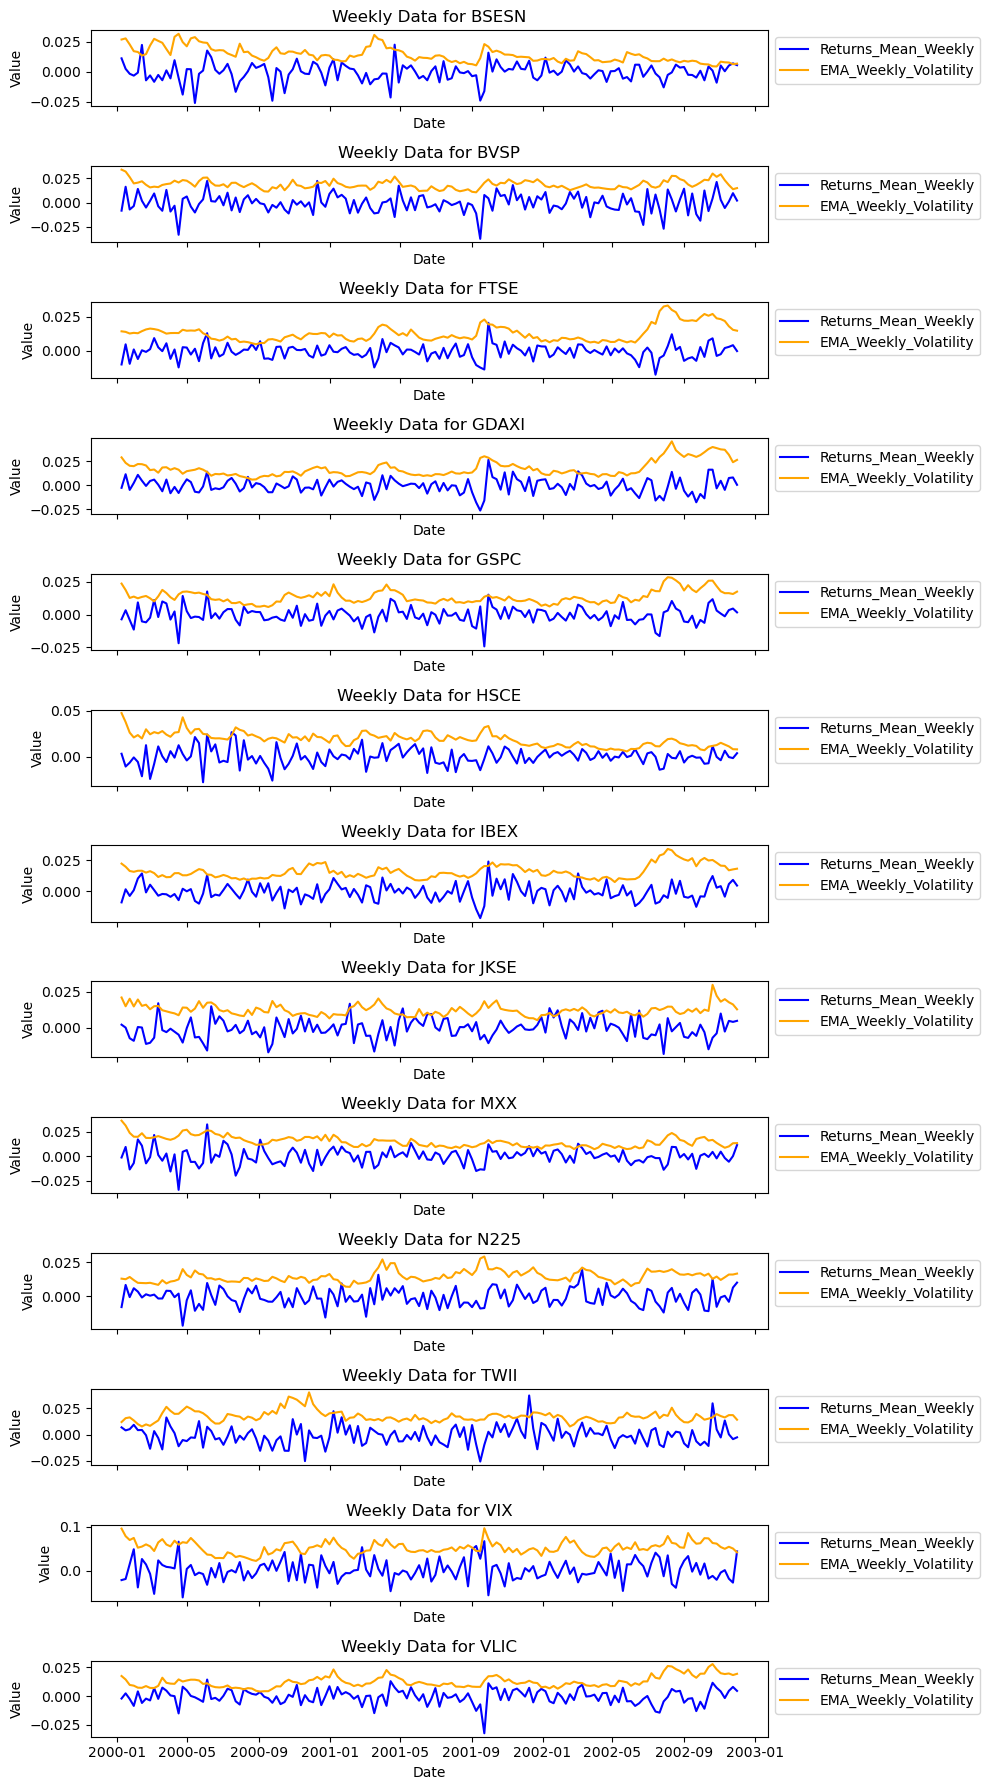

In [429]:
import matplotlib.pyplot as plt

def plot_market_data(df, title_prefix, columns_to_plot):
    # Get unique markets from the DataFrame
    markets = df['Market'].unique()
    # Determine the number of subplot rows needed (one for each market)
    nrows = len(markets)
    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(10, 18), sharex=True)
    
    # Check if only one market (single subplot scenario)
    if nrows == 1:
        axes = [axes]
    
    # Loop over each market and plot the data
    for i, market in enumerate(markets):
        # Filter the DataFrame for the current market
        market_data = df[df['Market'] == market]
        axes[i].plot(market_data['Date'], market_data[columns_to_plot[0]], color='blue', label=columns_to_plot[0])
        axes[i].plot(market_data['Date'], market_data[columns_to_plot[1]], color='orange', label=columns_to_plot[1])
        axes[i].set_title(f"{title_prefix} {market}")
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel('Value')
        axes[i].legend()
        axes[i].legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    plt.show()

# Columns to plot for weekly data
weekly_columns = ['Returns_Mean_Weekly', 'EMA_Weekly_Volatility'] 

# Plot weekly data
plot_market_data(weekly_df, "Weekly Data for", weekly_columns)



In [430]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

def check_stationarity(df, columns):
    # Get unique markets from the DataFrame
    markets = df['Market'].unique()
    non_stationary_series = []

    # Loop over each market
    for market in markets:
        market_data = df[df['Market'] == market]
        
        # Loop over each column to test
        for column in columns:
            # Perform ADF test
            result = adfuller(market_data[column])
            p_value = result[1]  # p-value is at index 1 of the result
            
            # Check the p-value to determine stationarity (p < 0.05 means stationary)
            if p_value >= 0.05:
                non_stationary_series.append(f"{market}: {column}")

    return non_stationary_series

# Specify the columns to test for stationarity
weekly_columns = ['Returns_Mean_Weekly', 'EMA_Weekly_Volatility']  

# Perform the stationarity check
non_stationary_results = check_stationarity(weekly_df, weekly_columns)

# Output the results
if non_stationary_results:
    print("Non-stationary series:")
    for series in non_stationary_results:
        print(series)
else:
    print("All series are stationary.")


Non-stationary series:
GDAXI: EMA_Weekly_Volatility
HSCE: EMA_Weekly_Volatility


In [431]:
import pandas as pd

def apply_diff_and_update(df, markets, column_name):
    # Loop over each specified market
    for market in markets:
        # Filter the DataFrame for the current market
        market_indices = df['Market'] == market
        
        # Apply diff() to the specified column and update the DataFrame
        df.loc[market_indices, column_name] = df.loc[market_indices, column_name].diff()

    # Drop the first row for each market where the diff will result in NaN
    df.dropna(subset=[column_name], inplace=True)

# Specify the markets and the column to apply diff
markets_to_diff = ['GDAXI', 'HSCE']
column_to_diff = 'EMA_Weekly_Volatility'

# Apply the diff and update the DataFrame
apply_diff_and_update(weekly_df, markets_to_diff, column_to_diff)

In [432]:
non_stationary_results = check_stationarity(weekly_df, weekly_columns)
# Output the results
if non_stationary_results:
    print("Non-stationary series:")
    for series in non_stationary_results:
        print(series)
else:
    print("All series are stationary.")


All series are stationary.


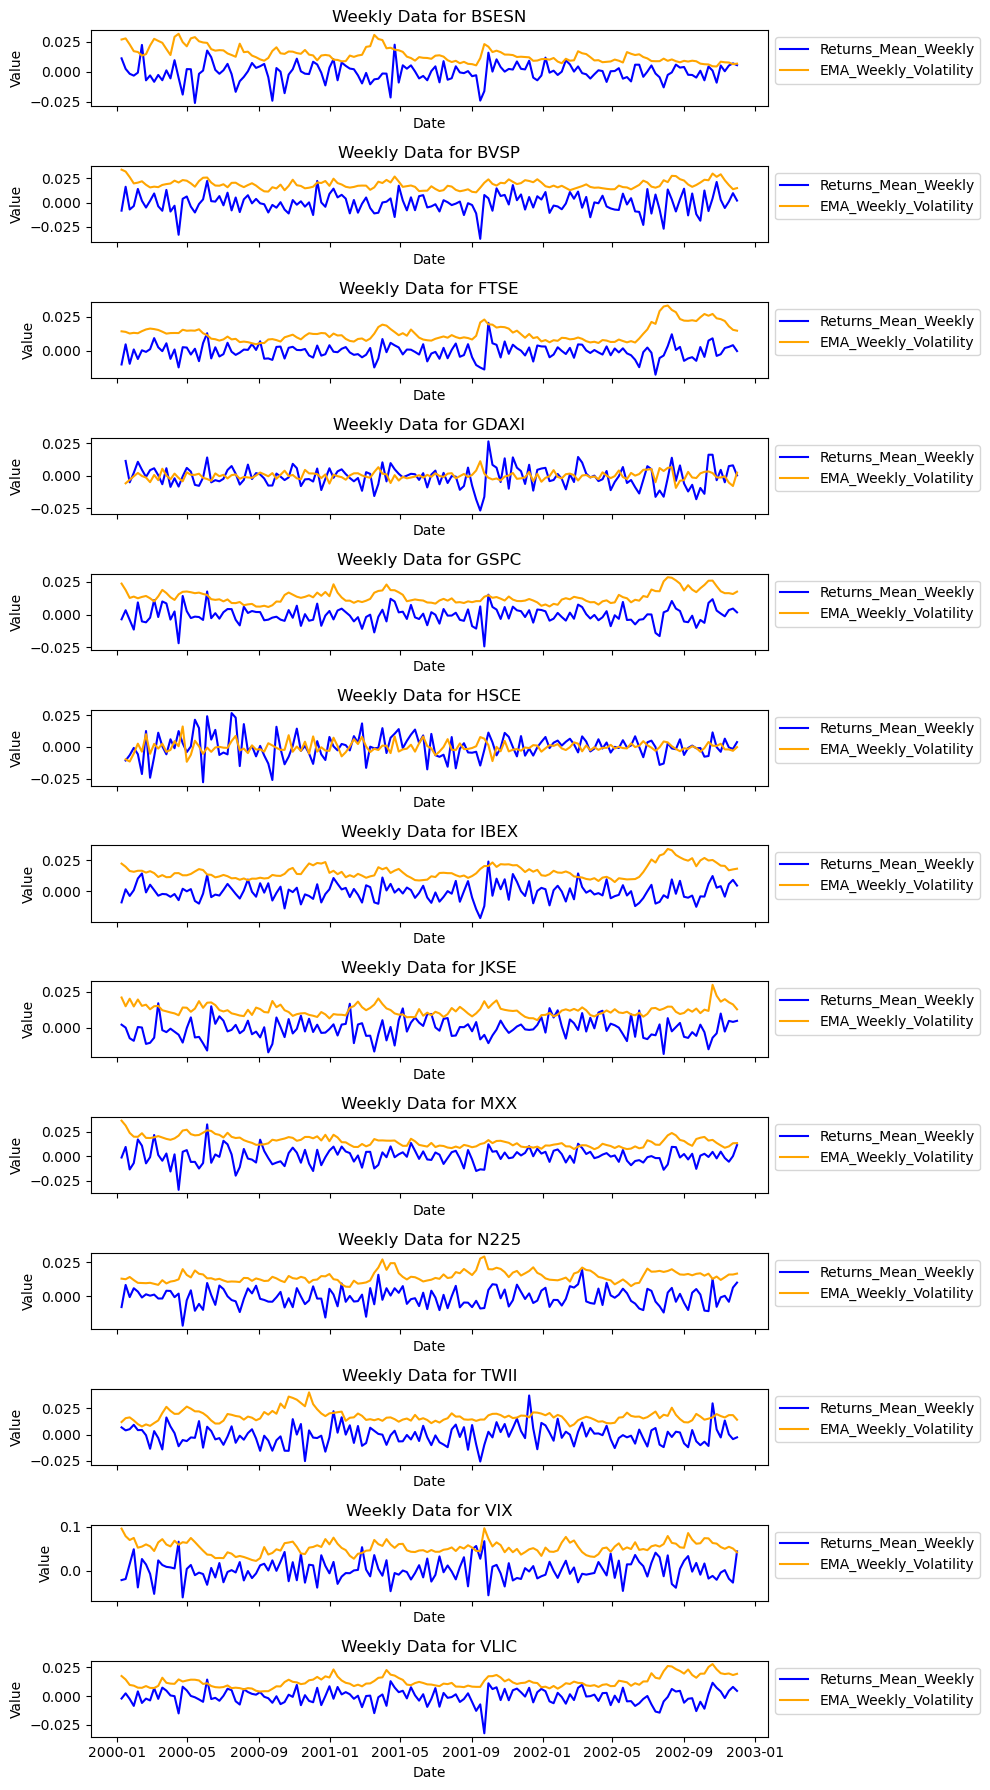

In [433]:
# Plot weekly data
plot_market_data(weekly_df, "Weekly Data for", weekly_columns)

## Monthly Stationarity 

In [434]:
# Filter the DataFrame for 'Market' equals 'FTSE' and select the 'EMA_Monthly_Volatility' column
ftse_monthly_volatility = monthly_df[monthly_df['Market'] == 'FTSE']['EMA_Monthly_Volatility']

# Print the results
print("EMA Monthly Volatility for FTSE:")
print(ftse_monthly_volatility)


EMA Monthly Volatility for FTSE:
70     0.013690
71     0.014386
72     0.013643
73     0.014196
74     0.013918
75     0.012299
76     0.010803
77     0.008548
78     0.009116
79     0.009890
80     0.010497
81     0.010680
82     0.010369
83     0.009319
84     0.013097
85     0.012415
86     0.012556
87     0.010904
88     0.011110
89     0.010085
90     0.016674
91     0.016557
92     0.013982
93     0.012558
94     0.011171
95     0.010244
96     0.008745
97     0.007995
98     0.007787
99     0.010697
100    0.018926
101    0.020568
102    0.021776
103    0.021970
104    0.018569
Name: EMA_Monthly_Volatility, dtype: float64


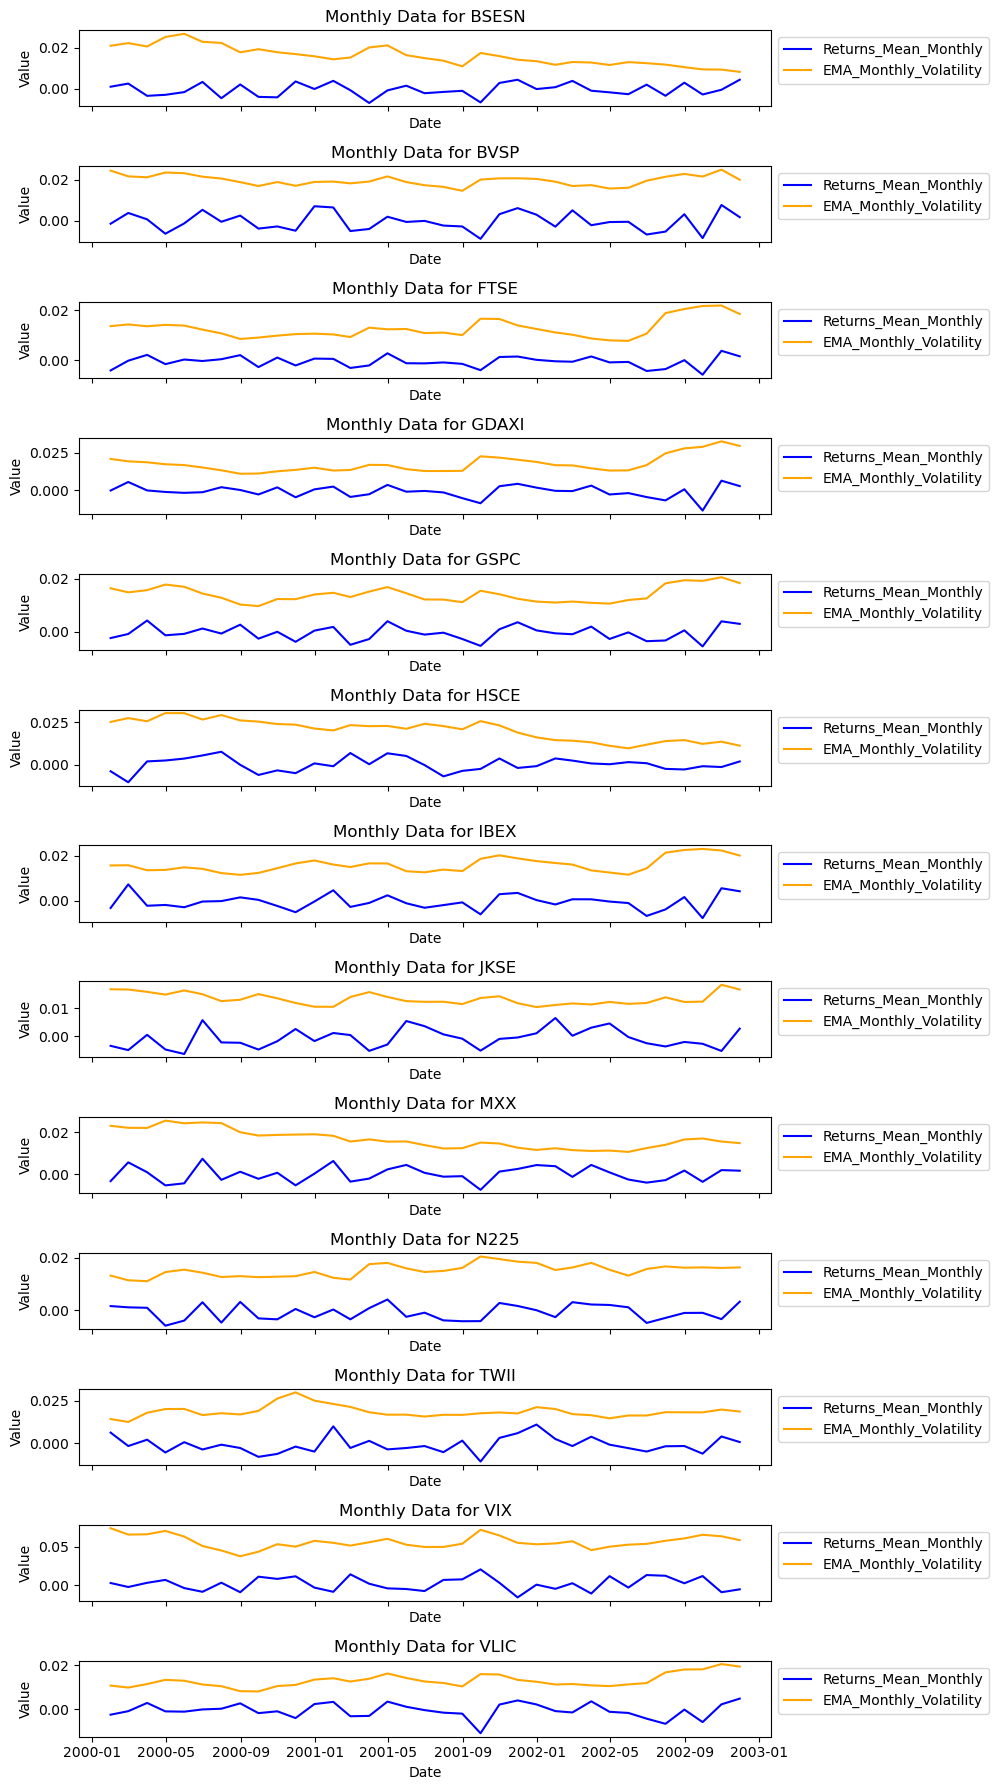

In [435]:
import matplotlib.pyplot as plt

def plot_market_data(df, title_prefix, columns_to_plot):
    # Get unique markets from the DataFrame
    markets = df['Market'].unique()
    # Determine the number of subplot rows needed (one for each market)
    nrows = len(markets)
    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(10, 18), sharex=True)
    
    # Check if only one market (single subplot scenario)
    if nrows == 1:
        axes = [axes]
    
    # Loop over each market and plot the data
    for i, market in enumerate(markets):
        # Filter the DataFrame for the current market
        market_data = df[df['Market'] == market]
        axes[i].plot(market_data['Date'], market_data[columns_to_plot[0]], color='blue', label=columns_to_plot[0])
        axes[i].plot(market_data['Date'], market_data[columns_to_plot[1]], color='orange', label=columns_to_plot[1])
        axes[i].set_title(f"{title_prefix} {market}")
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel('Value')
        axes[i].legend()
        axes[i].legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    plt.show()

# Columns to plot for monthly data
monthly_columns = ['Returns_Mean_Monthly', 'EMA_Monthly_Volatility']

# Plot monthly data
plot_market_data(monthly_df, "Monthly Data for", monthly_columns)


In [436]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

def check_stationarity(df, columns):
    # Get unique markets from the DataFrame
    markets = df['Market'].unique()
    non_stationary_series = []

    # Loop over each market
    for market in markets:
        market_data = df[df['Market'] == market]
        
        # Loop over each column to test
        for column in columns:
            # Perform ADF test
            result = adfuller(market_data[column])
            p_value = result[1]  # p-value is at index 1 of the result
            
            # Check the p-value to determine stationarity (p < 0.05 means stationary)
            if p_value >= 0.05:
                non_stationary_series.append(f"{market}: {column}")

    return non_stationary_series

# Perform the stationarity check for monthly data
non_stationary_results = check_stationarity(monthly_df, monthly_columns)

# Output the results
if non_stationary_results:
    print("Non-stationary series:")
    for series in non_stationary_results:
        print(series)
else:
    print("All series are stationary.")


Non-stationary series:
BSESN: EMA_Monthly_Volatility
FTSE: EMA_Monthly_Volatility
GDAXI: EMA_Monthly_Volatility
GSPC: EMA_Monthly_Volatility
HSCE: EMA_Monthly_Volatility
IBEX: EMA_Monthly_Volatility
JKSE: Returns_Mean_Monthly
JKSE: EMA_Monthly_Volatility
MXX: EMA_Monthly_Volatility
N225: EMA_Monthly_Volatility
TWII: EMA_Monthly_Volatility
VLIC: EMA_Monthly_Volatility


In [437]:
non_stationary_series = [
    "BSESN: EMA_Monthly_Volatility", "FTSE: EMA_Monthly_Volatility", "GDAXI: EMA_Monthly_Volatility",
    "GSPC: EMA_Monthly_Volatility", "HSCE: EMA_Monthly_Volatility", "IBEX: EMA_Monthly_Volatility",
    "JKSE: Returns_Mean_Monthly", "JKSE: EMA_Monthly_Volatility", "MXX: EMA_Monthly_Volatility",
    "N225: EMA_Monthly_Volatility", "TWII: EMA_Monthly_Volatility", "VLIC: EMA_Monthly_Volatility"
]

# Extract unique markets and columns to diff
markets_to_diff = set()
columns_to_diff = set()

for series in non_stationary_series:
    market, column = series.split(": ")
    markets_to_diff.add(market)
    columns_to_diff.add(column)

In [438]:
import pandas as pd

def apply_diff_and_update(df, markets, columns):
    # Loop over each specified market
    for market in markets:
        # Filter the DataFrame for the current market
        market_indices = df['Market'] == market
        
        # Apply diff() to each specified column and update the DataFrame
        for column in columns:
            df.loc[market_indices, column] = df.loc[market_indices, column].diff()

    # Drop the first row for each market where the diff will result in NaN
    df.dropna(subset=columns, inplace=True)

# Apply the diff and update the DataFrame for monthly data
apply_diff_and_update(monthly_df, markets_to_diff, columns_to_diff)



In [439]:
# Perform the stationarity check for monthly data
non_stationary_results = check_stationarity(monthly_df, monthly_columns)

# Output the results
if non_stationary_results:
    print("Non-stationary series:")
    for series in non_stationary_results:
        print(series)
else:
    print("All series are stationary.")


Non-stationary series:
FTSE: EMA_Monthly_Volatility


In [440]:
import pandas as pd

def apply_additional_diff(df, market, column):
    # Filter the DataFrame for the specific market
    market_indices = df['Market'] == market
    
    # Apply diff() to the specified column and update the DataFrame
    df.loc[market_indices, column] = df.loc[market_indices, column].diff()

    # Drop rows where the result of diff() results in NaN
    df.dropna(subset=[column], inplace=True)

# Specify the market and the column to apply an additional diff
market_to_diff = 'FTSE'
column_to_diff = 'EMA_Monthly_Volatility'

# Apply the additional diff and update the DataFrame
apply_additional_diff(monthly_df, market_to_diff, column_to_diff)

# Print out a few rows to confirm the change
print(monthly_df[monthly_df['Market'] == market_to_diff][['Market', 'Date', column_to_diff]].head())


   Market       Date  EMA_Monthly_Volatility
72   FTSE 2000-03-31               -0.001439
73   FTSE 2000-04-30                0.001295
74   FTSE 2000-05-31               -0.000830
75   FTSE 2000-06-30               -0.001341
76   FTSE 2000-07-31                0.000123


In [441]:
# Perform the stationarity check for monthly data
non_stationary_results = check_stationarity(monthly_df, monthly_columns)

# Output the results
if non_stationary_results:
    print("Non-stationary series:")
    for series in non_stationary_results:
        print(series)
else:
    print("All series are stationary.")


All series are stationary.


In [442]:
# Filter the DataFrame for 'Market' equals 'FTSE' and select the 'EMA_Monthly_Volatility' column
ftse_monthly_volatility = monthly_df[monthly_df['Market'] == 'FTSE']['EMA_Monthly_Volatility']

# Print the results
print("EMA Monthly Volatility for FTSE:")
print(ftse_monthly_volatility)

EMA Monthly Volatility for FTSE:
72    -0.001439
73     0.001295
74    -0.000830
75    -0.001341
76     0.000123
77    -0.000759
78     0.002824
79     0.000206
80    -0.000167
81    -0.000424
82    -0.000495
83    -0.000738
84     0.004827
85    -0.004460
86     0.000823
87    -0.001792
88     0.001857
89    -0.001230
90     0.007615
91    -0.006707
92    -0.002458
93     0.001151
94     0.000037
95     0.000459
96    -0.000572
97     0.000750
98     0.000542
99     0.003118
100    0.005319
101   -0.006587
102   -0.000435
103   -0.001012
104   -0.003597
Name: EMA_Monthly_Volatility, dtype: float64


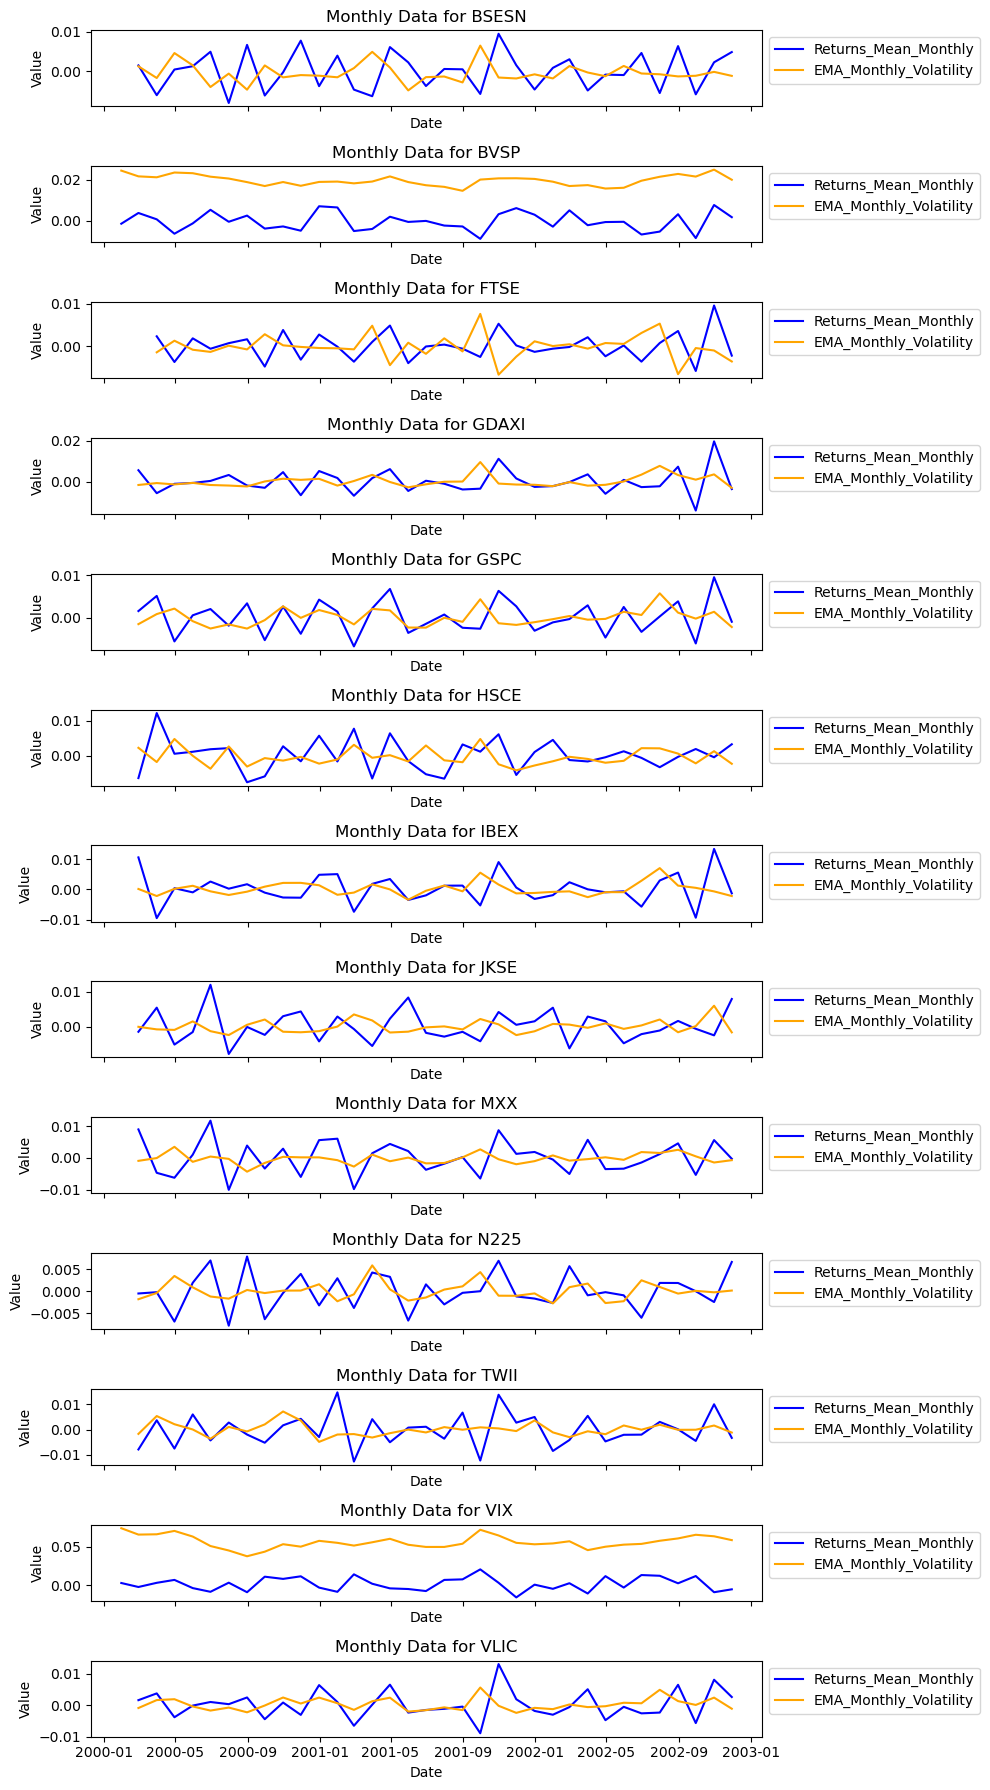

In [443]:
# Plot monthly data
plot_market_data(monthly_df, "Monthly Data for", monthly_columns)

# 4. CAUSALITY ANALYSIS

In this chapter, we apply the granger causality to create the matrixes as mentioned in the exercise.

[Back to Index](#INDEX)

In [444]:
weekly_df

Market       Date   Open first     High max      Low min   Close last  \
0     BSESN 2000-01-09  7814.310059  8300.969970  7776.719970  8121.719970   
1     BSESN 2000-01-16  8426.384766  8502.419678  7831.919678  8206.905030   
2     BSESN 2000-01-23  8426.550293  8496.750000  7995.120117  8134.574707   
3     BSESN 2000-01-30  8294.069824  8374.830322  7997.310059  8003.699707   
4     BSESN 2000-02-06  8008.004883  8104.050293  7691.685059  7970.384766   
...     ...        ...          ...          ...          ...          ...   
1971   VLIC 2002-11-03   385.814987   393.509994   373.530006   393.509994   
1972   VLIC 2002-11-10   393.509994   405.644990   389.009994   389.865006   
1973   VLIC 2002-11-17   389.865006   398.789977   379.290002   398.445007   
1974   VLIC 2002-11-24   398.445007   416.279984   392.070007   414.390015   
1975   VLIC 2002-12-01   414.390015   424.890015   410.384994   421.634994   

      Volume mean  Adj Close last  Returns Last  Returns Volatility  \
0             0.0     8121.719970     -0.001300            0.026863   
1             0.0     8206.905030      0.004858            0.029187   
2             0.0     8134.574707      0.012556            0.015210   
3             0.0     8003.699707     -0.006202            0.008693   
4             0.0     7970.384766     -0.004981            0.015509   
...           ...             ...           ...                 ...   
1971   14511000.0      393.509994      0.025006            0.014885   
1972   14289000.0      389.865006     -0.014447            0.018049   
1973   14202000.0      398.445007      0.005527            0.020451   
1974   21141000.0      414.390015      0.004107            0.016238   
1975   18176250.0      421.634994     -0.003969            0.021006   

      Returns_Mean_Weekly  EMA_Weekly_Volatility  
0                0.011181               0.026863  
1                0.002431               0.027792  
2               -0.001676               0.022760  
3               -0.003208               0.017133  
4               -0.000737               0.016483  
...                   ...                    ...  
1971             0.004045               0.019902  
1972            -0.001729               0.019161  
1973             0.004531               0.019677  
1974             0.007983               0.018301  
1975             0.004507               0.019383  

[1974 rows x 12 columns]

In [445]:
monthly_df

Market       Date   Open first     High max      Low min   Close last  \
1    BSESN 2000-02-29  7826.474853  9226.034911  7691.685059  8171.205322   
2    BSESN 2000-03-31  8196.974853  8743.185059  7300.844970  7501.919678   
3    BSESN 2000-04-30  7605.750000  8314.215089  6426.254883  6986.324707   
4    BSESN 2000-05-31  7135.900147  7136.835206  5747.790160  6650.414794   
5    BSESN 2000-06-30  6609.780030  7379.444824  6481.889649  7123.155030   
..     ...        ...          ...          ...          ...          ...   
450   VLIC 2002-07-31   486.464997   486.464997   373.860007   417.449982   
451   VLIC 2002-08-31   417.449982   437.880020   384.480010   414.195007   
452   VLIC 2002-09-30   414.195007   418.380020   359.474991   366.974991   
453   VLIC 2002-10-31   366.974991   389.490006   326.519990   383.910003   
454   VLIC 2002-11-30   383.910003   424.890015   379.290002   421.634994   

      Volume mean  Adj Close last  Returns Last  Returns Volatility  \
1    0.000000e+00     8171.205322     -0.051077            0.024254   
2    0.000000e+00     7501.919678     -0.007895            0.018175   
3    0.000000e+00     6986.324707     -0.004718            0.032307   
4    0.000000e+00     6650.414794      0.028258            0.029217   
5    0.000000e+00     7123.155030     -0.007702            0.017038   
..            ...             ...           ...                 ...   
450  1.606364e+07      417.449982     -0.011649            0.024207   
451  1.228295e+07      414.195007     -0.004471            0.020103   
452  1.214100e+07      366.974991     -0.008872            0.018351   
453  1.516043e+07      383.910003     -0.000625            0.024246   
454  1.680150e+07      421.634994     -0.003969            0.017811   

     Returns_Mean_Monthly  EMA_Monthly_Volatility  
1                0.001537                0.001300  
2               -0.006001               -0.001651  
3                0.000493                0.004662  
4                0.001327                0.001561  
5                0.004995               -0.003935  
..                    ...                     ...  
450             -0.002360                0.004903  
451              0.006499                0.001300  
452             -0.005711                0.000079  
453              0.008117                0.002406  
454              0.002604               -0.001131  

[443 rows x 12 columns]

## 4.1 Weekly Causality

In [446]:
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

# Get unique markets
markets = weekly_df['Market'].unique()

# Initialize matrices to store results
weekly_results_returns = pd.DataFrame(index=markets, columns=markets, dtype=object)
weekly_results_volatility = pd.DataFrame(index=markets, columns=markets, dtype=object)

# Function to perform Granger Causality for each lag and return results
def test_granger(dataframe, maxlag):
    test_result = grangercausalitytests(dataframe, maxlag=maxlag)
    # Collect the p-values for each lag in a tuple
    results = tuple(1 if test_result[lag][0]['ssr_chi2test'][1] < 0.05 else 0 for lag in range(1, maxlag + 1))
    return results

# Loop over each pair of markets
for market1 in markets:
    for market2 in markets:
        if market1 != market2:
            # Prepare data for each market pair by filtering DataFrame
            data1 = weekly_df[weekly_df['Market'] == market1]['Returns_Mean_Weekly']
            data2 = weekly_df[weekly_df['Market'] == market2]['Returns_Mean_Weekly']
            merged_returns = pd.concat([data1.reset_index(drop=True), data2.reset_index(drop=True)], axis=1).dropna()

            data1_vol = weekly_df[weekly_df['Market'] == market1]['EMA_Weekly_Volatility']
            data2_vol = weekly_df[weekly_df['Market'] == market2]['EMA_Weekly_Volatility']
            merged_volatility = pd.concat([data1_vol.reset_index(drop=True), data2_vol.reset_index(drop=True)], axis=1).dropna()

            # Granger Causality Test for Returns Mean Weekly
            if not merged_returns.empty:
                weekly_results_returns.at[market1, market2] = test_granger(merged_returns, maxlag=4)

            # Granger Causality Test for EMA Weekly Volatility
            if not merged_volatility.empty:
                weekly_results_volatility.at[market1, market2] = test_granger(merged_volatility, maxlag=4)

# Fill diagonal where market comparison would be self to self 
for market in markets:
    weekly_results_returns.at[market, market] = ("-")
    weekly_results_volatility.at[market, market] = ("-")






Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.1911 , p=0.0002  , df_denom=148, df_num=1
ssr based chi2 test:   chi2=14.4788 , p=0.0001  , df=1
likelihood ratio test: chi2=13.8261 , p=0.0002  , df=1
parameter F test:         F=14.1911 , p=0.0002  , df_denom=148, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.5736  , p=0.0007  , df_denom=145, df_num=2
ssr based chi2 test:   chi2=15.6696 , p=0.0004  , df=2
likelihood ratio test: chi2=14.9040 , p=0.0006  , df=2
parameter F test:         F=7.5736  , p=0.0007  , df_denom=145, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.3295  , p=0.0017  , df_denom=142, df_num=3
ssr based chi2 test:   chi2=16.7766 , p=0.0008  , df=3
likelihood ratio test: chi2=15.8975 , p=0.0012  , df=3
parameter F test:         F=5.3295  , p=0.0017  , df_denom=142, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.0298  , p=0.0008  

In [447]:
print("Granger Causality Results for Returns Mean Weekly:")
weekly_results_returns


Granger Causality Results for Returns Mean Weekly:


BSESN          BVSP          FTSE         GDAXI          GSPC  \
BSESN             -  (1, 1, 1, 1)  (1, 1, 1, 0)  (1, 1, 1, 1)  (1, 1, 1, 1)   
BVSP   (0, 0, 0, 0)             -  (1, 1, 1, 1)  (1, 1, 1, 1)  (1, 1, 1, 1)   
FTSE   (0, 1, 0, 0)  (0, 0, 0, 0)             -  (1, 1, 1, 1)  (0, 0, 0, 0)   
GDAXI  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)             -  (0, 0, 0, 0)   
GSPC   (0, 0, 0, 0)  (0, 0, 0, 0)  (1, 1, 1, 1)  (1, 1, 1, 1)             -   
HSCE   (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (1, 0, 0, 0)  (1, 0, 0, 0)   
IBEX   (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (1, 1, 1, 1)  (0, 0, 0, 0)   
JKSE   (0, 0, 0, 0)  (0, 0, 1, 1)  (0, 1, 1, 1)  (0, 0, 0, 1)  (1, 1, 1, 1)   
MXX    (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (1, 1, 1, 1)  (0, 0, 0, 0)   
N225   (0, 0, 0, 0)  (1, 1, 1, 1)  (1, 1, 1, 1)  (1, 1, 1, 1)  (1, 1, 1, 1)   
TWII   (0, 0, 0, 0)  (1, 1, 1, 0)  (1, 1, 1, 1)  (1, 1, 1, 1)  (1, 1, 1, 1)   
VIX    (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (1, 1, 1, 1)  (0, 1, 0, 0)   
VLIC   (0, 0, 0, 0)  (0, 0, 0, 0)  (1, 1, 1, 1)  (1, 1, 1, 1)  (0, 0, 0, 0)   

               HSCE          IBEX          JKSE           MXX          N225  \
BSESN  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (1, 1, 1, 1)  (0, 0, 0, 0)   
BVSP   (0, 0, 0, 0)  (1, 1, 1, 1)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)   
FTSE   (1, 1, 1, 1)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)   
GDAXI  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)   
GSPC   (1, 1, 1, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)   
HSCE              -  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 1)   
IBEX   (0, 0, 0, 0)             -  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)   
JKSE   (0, 1, 1, 1)  (0, 0, 0, 0)             -  (1, 1, 1, 1)  (0, 0, 0, 0)   
MXX    (0, 0, 1, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)             -  (0, 0, 0, 0)   
N225   (1, 1, 1, 1)  (1, 1, 1, 1)  (0, 0, 0, 0)  (1, 0, 0, 0)             -   
TWII   (1, 1, 1, 1)  (1, 1, 1, 1)  (0, 0, 0, 0)  (1, 1, 1, 1)  (0, 0, 0, 0)   
VIX    (1, 1, 1, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)   
VLIC   (1, 1, 1, 1)  (1, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)   

               TWII           VIX          VLIC  
BSESN  (0, 0, 0, 0)  (1, 1, 1, 1)  (1, 1, 1, 0)  
BVSP   (0, 0, 0, 0)  (1, 1, 1, 1)  (1, 1, 1, 1)  
FTSE   (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  
GDAXI  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  
GSPC   (0, 0, 0, 1)  (0, 0, 0, 0)  (0, 0, 0, 0)  
HSCE   (0, 0, 0, 0)  (1, 1, 1, 0)  (0, 0, 0, 0)  
IBEX   (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  
JKSE   (0, 0, 0, 0)  (1, 1, 1, 1)  (1, 1, 1, 1)  
MXX    (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  
N225   (0, 0, 0, 0)  (1, 1, 1, 1)  (1, 1, 1, 1)  
TWII              -  (1, 1, 1, 1)  (1, 1, 1, 1)  
VIX    (0, 0, 0, 0)             -  (0, 0, 0, 0)  
VLIC   (0, 0, 0, 0)  (0, 0, 0, 0)             -

In [448]:
print("\nGranger Causality Results for EMA Weekly Volatility:")
weekly_results_volatility



Granger Causality Results for EMA Weekly Volatility:


BSESN          BVSP          FTSE         GDAXI          GSPC  \
BSESN             -  (0, 0, 0, 0)  (0, 1, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)   
BVSP   (0, 0, 0, 0)             -  (1, 1, 1, 1)  (1, 1, 1, 1)  (1, 1, 1, 1)   
FTSE   (0, 0, 0, 0)  (1, 1, 1, 1)             -  (1, 1, 1, 1)  (0, 0, 0, 0)   
GDAXI  (0, 0, 0, 0)  (1, 1, 1, 1)  (0, 1, 1, 1)             -  (0, 1, 1, 1)   
GSPC   (0, 0, 0, 1)  (1, 1, 0, 1)  (1, 1, 1, 1)  (1, 1, 1, 1)             -   
HSCE   (1, 0, 0, 0)  (1, 1, 0, 0)  (0, 0, 0, 0)  (0, 1, 1, 1)  (0, 0, 0, 0)   
IBEX   (0, 0, 0, 0)  (1, 1, 0, 0)  (1, 1, 1, 1)  (1, 1, 1, 1)  (0, 0, 0, 0)   
JKSE   (0, 0, 0, 0)  (0, 0, 0, 0)  (1, 0, 0, 0)  (1, 0, 0, 0)  (0, 0, 0, 0)   
MXX    (1, 1, 1, 1)  (0, 0, 0, 0)  (0, 0, 0, 1)  (1, 0, 0, 0)  (0, 0, 0, 0)   
N225   (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 1, 1, 1)  (1, 1, 1, 1)  (0, 1, 1, 0)   
TWII   (0, 0, 1, 1)  (0, 0, 0, 0)  (0, 1, 1, 0)  (0, 1, 0, 0)  (0, 1, 1, 1)   
VIX    (0, 0, 0, 0)  (0, 0, 0, 0)  (1, 1, 1, 1)  (1, 1, 1, 1)  (0, 0, 0, 0)   
VLIC   (0, 0, 0, 1)  (0, 0, 1, 1)  (1, 1, 1, 1)  (1, 1, 1, 1)  (0, 0, 0, 0)   

               HSCE          IBEX          JKSE           MXX          N225  \
BSESN  (0, 0, 0, 0)  (0, 1, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)   
BVSP   (1, 1, 1, 1)  (1, 1, 1, 1)  (0, 0, 0, 0)  (0, 0, 0, 0)  (1, 1, 1, 1)   
FTSE   (1, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 1, 1, 0)   
GDAXI  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)   
GSPC   (1, 1, 0, 0)  (1, 1, 1, 1)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 1, 1, 1)   
HSCE              -  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (1, 1, 1, 0)   
IBEX   (0, 0, 0, 0)             -  (0, 0, 0, 0)  (0, 0, 0, 0)  (1, 1, 1, 1)   
JKSE   (0, 0, 0, 0)  (0, 0, 0, 0)             -  (0, 0, 0, 0)  (0, 0, 0, 0)   
MXX    (1, 1, 1, 1)  (0, 0, 0, 0)  (0, 0, 0, 0)             -  (0, 0, 0, 0)   
N225   (1, 1, 1, 1)  (0, 1, 1, 1)  (0, 0, 0, 0)  (0, 1, 1, 0)             -   
TWII   (0, 1, 1, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 1, 1, 0)  (0, 0, 0, 0)   
VIX    (0, 0, 0, 0)  (1, 0, 1, 1)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 1, 0, 0)   
VLIC   (1, 1, 0, 0)  (1, 1, 1, 1)  (0, 0, 0, 0)  (0, 1, 1, 1)  (1, 1, 1, 1)   

               TWII           VIX          VLIC  
BSESN  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 1)  
BVSP   (0, 0, 0, 0)  (1, 1, 1, 1)  (1, 1, 1, 1)  
FTSE   (0, 0, 0, 0)  (0, 0, 0, 0)  (1, 0, 1, 0)  
GDAXI  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 1, 1, 0)  
GSPC   (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  
HSCE   (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  
IBEX   (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  
JKSE   (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  
MXX    (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  
N225   (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  
TWII              -  (0, 0, 0, 0)  (0, 1, 1, 1)  
VIX    (0, 0, 0, 0)             -  (0, 0, 0, 0)  
VLIC   (0, 0, 0, 0)  (0, 0, 0, 0)             -

## 4.2 Monthly Causality

In [449]:
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

# Get unique markets from the DataFrame
markets = monthly_df['Market'].unique()

# Initialize matrices to store results
monthly_results_returns = pd.DataFrame(index=markets, columns=markets, dtype=object)
monthly_results_volatility = pd.DataFrame(index=markets, columns=markets, dtype=object)

# Function to perform Granger Causality for each lag and return results
def test_granger(dataframe, maxlag):
    test_result = grangercausalitytests(dataframe, maxlag=maxlag)
    # Collect the p-values for each lag in a tuple
    results = tuple(1 if test_result[lag][0]['ssr_chi2test'][1] < 0.05 else 0 for lag in range(1, maxlag + 1))
    return results

# Loop over each pair of markets
for market1 in markets:
    for market2 in markets:
        if market1 != market2:
            # Prepare data for each market pair by filtering DataFrame
            data1 = monthly_df[monthly_df['Market'] == market1]['Returns_Mean_Monthly']  
            data2 = monthly_df[monthly_df['Market'] == market2]['Returns_Mean_Monthly']
            merged_returns = pd.concat([data1.reset_index(drop=True), data2.reset_index(drop=True)], axis=1).dropna()

            data1_vol = monthly_df[monthly_df['Market'] == market1]['EMA_Monthly_Volatility'] 
            data2_vol = monthly_df[monthly_df['Market'] == market2]['EMA_Monthly_Volatility']
            merged_volatility = pd.concat([data1_vol.reset_index(drop=True), data2_vol.reset_index(drop=True)], axis=1).dropna()

            # Granger Causality Test for Returns Mean Monthly
            if not merged_returns.empty:
                monthly_results_returns.at[market1, market2] = test_granger(merged_returns, maxlag=4)

            # Granger Causality Test for EMA Monthly Volatility
            if not merged_volatility.empty:
                monthly_results_volatility.at[market1, market2] = test_granger(merged_volatility, maxlag=4)

# Fill diagonal where market comparison would be self to self 
for market in markets:
    monthly_results_returns.at[market, market] = ("-")
    monthly_results_volatility.at[market, market] = ("-")



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=16.1874 , p=0.0004  , df_denom=30, df_num=1
ssr based chi2 test:   chi2=17.8062 , p=0.0000  , df=1
likelihood ratio test: chi2=14.2399 , p=0.0002  , df=1
parameter F test:         F=16.1874 , p=0.0004  , df_denom=30, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.9833  , p=0.0010  , df_denom=27, df_num=2
ssr based chi2 test:   chi2=21.2938 , p=0.0000  , df=2
likelihood ratio test: chi2=16.3227 , p=0.0003  , df=2
parameter F test:         F=8.9833  , p=0.0010  , df_denom=27, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.4225  , p=0.0054  , df_denom=24, df_num=3
ssr based chi2 test:   chi2=21.0122 , p=0.0001  , df=3
likelihood ratio test: chi2=16.0422 , p=0.0011  , df=3
parameter F test:         F=5.4225  , p=0.0054  , df_denom=24, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.9554  , p=0.0440  , df_d

In [450]:
print("Granger Causality Results for Returns Mean Monthly:")
monthly_results_returns


Granger Causality Results for Returns Mean Monthly:


BSESN          BVSP          FTSE         GDAXI          GSPC  \
BSESN             -  (1, 1, 1, 1)  (0, 1, 1, 1)  (1, 1, 1, 1)  (1, 1, 1, 1)   
BVSP   (1, 0, 1, 1)             -  (1, 1, 1, 1)  (1, 1, 1, 1)  (1, 1, 1, 1)   
FTSE   (0, 0, 0, 0)  (0, 0, 0, 0)             -  (1, 0, 0, 0)  (1, 0, 0, 0)   
GDAXI  (0, 0, 0, 0)  (1, 0, 0, 0)  (1, 1, 1, 1)             -  (0, 0, 0, 0)   
GSPC   (0, 0, 0, 0)  (1, 1, 1, 0)  (1, 1, 1, 1)  (0, 0, 0, 0)             -   
HSCE   (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)   
IBEX   (0, 1, 0, 0)  (1, 0, 0, 0)  (1, 1, 1, 1)  (0, 0, 0, 0)  (0, 0, 0, 0)   
JKSE   (0, 0, 0, 0)  (1, 0, 0, 0)  (0, 0, 0, 1)  (1, 1, 1, 0)  (1, 0, 1, 1)   
MXX    (0, 1, 1, 0)  (1, 1, 0, 0)  (1, 1, 1, 1)  (0, 0, 0, 0)  (0, 0, 0, 0)   
N225   (0, 0, 0, 0)  (1, 1, 1, 1)  (0, 1, 1, 1)  (0, 1, 1, 0)  (0, 1, 1, 1)   
TWII   (0, 0, 0, 0)  (1, 1, 1, 1)  (1, 1, 1, 1)  (0, 0, 0, 0)  (0, 0, 0, 0)   
VIX    (0, 0, 1, 1)  (0, 0, 0, 1)  (1, 1, 1, 1)  (1, 1, 1, 1)  (1, 1, 1, 1)   
VLIC   (0, 0, 0, 0)  (1, 1, 0, 0)  (1, 1, 1, 1)  (0, 0, 0, 0)  (0, 0, 0, 0)   

               HSCE          IBEX          JKSE           MXX          N225  \
BSESN  (0, 0, 0, 0)  (0, 0, 1, 1)  (0, 0, 0, 1)  (0, 0, 0, 0)  (0, 0, 0, 0)   
BVSP   (0, 0, 0, 0)  (1, 1, 1, 1)  (0, 0, 1, 1)  (1, 1, 1, 1)  (0, 0, 1, 1)   
FTSE   (0, 0, 0, 0)  (1, 0, 0, 1)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)   
GDAXI  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 1, 1, 0)   
GSPC   (0, 0, 0, 1)  (0, 0, 0, 1)  (1, 0, 1, 0)  (0, 0, 0, 0)  (0, 1, 1, 0)   
HSCE              -  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)   
IBEX   (0, 0, 0, 0)             -  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)   
JKSE   (0, 0, 0, 0)  (1, 0, 0, 0)             -  (1, 1, 0, 0)  (0, 0, 0, 0)   
MXX    (0, 0, 1, 1)  (0, 0, 0, 0)  (1, 0, 0, 1)             -  (0, 0, 0, 0)   
N225   (0, 0, 0, 1)  (0, 0, 0, 1)  (1, 0, 0, 0)  (0, 0, 0, 0)             -   
TWII   (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)   
VIX    (0, 0, 1, 1)  (1, 1, 1, 1)  (0, 0, 1, 1)  (1, 1, 1, 1)  (0, 0, 0, 1)   
VLIC   (0, 0, 0, 1)  (0, 0, 0, 1)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 1, 0, 0)   

               TWII           VIX          VLIC  
BSESN  (0, 0, 0, 0)  (1, 1, 1, 1)  (0, 1, 0, 0)  
BVSP   (1, 1, 1, 1)  (0, 0, 0, 1)  (1, 1, 1, 1)  
FTSE   (0, 0, 0, 0)  (0, 1, 0, 1)  (1, 0, 0, 0)  
GDAXI  (0, 0, 0, 0)  (1, 1, 1, 1)  (0, 0, 0, 0)  
GSPC   (0, 0, 0, 0)  (1, 1, 1, 1)  (0, 0, 0, 0)  
HSCE   (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  
IBEX   (0, 0, 0, 0)  (1, 1, 1, 1)  (0, 0, 0, 0)  
JKSE   (0, 0, 0, 0)  (0, 0, 0, 0)  (1, 0, 1, 0)  
MXX    (0, 0, 0, 0)  (1, 1, 1, 1)  (0, 0, 0, 0)  
N225   (0, 0, 0, 0)  (1, 1, 0, 1)  (0, 1, 1, 0)  
TWII              -  (1, 1, 1, 1)  (0, 0, 0, 0)  
VIX    (1, 1, 1, 1)             -  (1, 1, 1, 1)  
VLIC   (0, 0, 0, 0)  (1, 1, 1, 1)             -

In [451]:
print("\nGranger Causality Results for EMA Monthly Volatility:")
monthly_results_volatility


Granger Causality Results for EMA Monthly Volatility:


BSESN          BVSP          FTSE         GDAXI          GSPC  \
BSESN             -  (0, 0, 0, 0)  (1, 1, 1, 1)  (0, 0, 0, 0)  (0, 0, 0, 0)   
BVSP   (1, 1, 1, 1)             -  (1, 1, 1, 1)  (1, 1, 1, 1)  (1, 1, 1, 1)   
FTSE   (0, 0, 0, 0)  (0, 0, 1, 0)             -  (1, 1, 1, 1)  (0, 0, 1, 1)   
GDAXI  (0, 0, 0, 0)  (1, 1, 0, 0)  (1, 1, 1, 1)             -  (0, 0, 0, 0)   
GSPC   (0, 0, 0, 0)  (1, 1, 1, 0)  (1, 1, 1, 1)  (0, 0, 0, 0)             -   
HSCE   (0, 0, 0, 0)  (0, 0, 0, 0)  (1, 1, 1, 1)  (0, 0, 0, 0)  (0, 0, 0, 0)   
IBEX   (0, 0, 0, 0)  (1, 0, 0, 0)  (1, 1, 1, 1)  (0, 0, 0, 0)  (0, 0, 0, 0)   
JKSE   (0, 0, 0, 0)  (0, 0, 0, 0)  (1, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)   
MXX    (0, 0, 0, 0)  (0, 0, 0, 0)  (1, 0, 1, 1)  (0, 0, 1, 0)  (0, 1, 0, 1)   
N225   (0, 0, 0, 1)  (0, 0, 0, 0)  (1, 0, 1, 1)  (0, 0, 0, 0)  (0, 0, 0, 0)   
TWII   (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)   
VIX    (1, 1, 1, 1)  (1, 0, 0, 0)  (1, 1, 1, 0)  (1, 1, 1, 1)  (1, 1, 1, 1)   
VLIC   (0, 0, 0, 1)  (0, 0, 1, 0)  (1, 1, 1, 1)  (1, 1, 1, 1)  (0, 1, 1, 0)   

               HSCE          IBEX          JKSE           MXX          N225  \
BSESN  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)   
BVSP   (1, 1, 1, 1)  (1, 1, 1, 1)  (0, 0, 0, 1)  (1, 1, 1, 1)  (1, 1, 1, 1)   
FTSE   (1, 0, 0, 0)  (1, 1, 1, 1)  (0, 0, 0, 0)  (1, 1, 1, 0)  (1, 1, 1, 1)   
GDAXI  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 1)   
GSPC   (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 1, 1, 1)  (0, 1, 1, 1)   
HSCE              -  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)   
IBEX   (0, 0, 0, 0)             -  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 1, 0, 1)   
JKSE   (0, 0, 0, 0)  (0, 0, 0, 0)             -  (0, 0, 0, 0)  (0, 0, 0, 0)   
MXX    (0, 0, 0, 0)  (0, 0, 1, 0)  (0, 0, 0, 0)             -  (0, 0, 0, 1)   
N225   (0, 0, 0, 1)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)             -   
TWII   (0, 0, 1, 1)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)   
VIX    (1, 0, 1, 0)  (1, 1, 1, 1)  (0, 0, 0, 0)  (1, 1, 1, 1)  (1, 1, 1, 1)   
VLIC   (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 1, 1, 1)  (0, 1, 1, 1)   

               TWII           VIX          VLIC  
BSESN  (0, 0, 1, 1)  (0, 0, 0, 0)  (0, 0, 0, 0)  
BVSP   (0, 0, 0, 0)  (1, 1, 1, 0)  (1, 1, 1, 1)  
FTSE   (0, 0, 0, 0)  (0, 0, 1, 1)  (1, 0, 1, 1)  
GDAXI  (0, 0, 0, 0)  (0, 0, 0, 0)  (1, 1, 1, 1)  
GSPC   (0, 0, 0, 0)  (1, 1, 1, 1)  (0, 1, 1, 0)  
HSCE   (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  
IBEX   (0, 0, 1, 1)  (1, 0, 0, 0)  (0, 0, 0, 0)  
JKSE   (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  
MXX    (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  
N225   (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  
TWII              -  (0, 1, 1, 1)  (0, 0, 0, 0)  
VIX    (0, 0, 0, 0)             -  (1, 1, 1, 1)  
VLIC   (0, 0, 0, 0)  (0, 0, 1, 1)             -